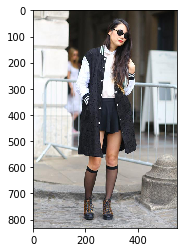

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 19 19 19 19 19 19 19 19 19 19 19 19 19 41 41 41
 41 41]
(832, 550, 3)
(832, 550)


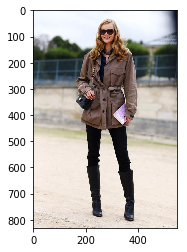

[19 19 19 19 19 19 19 19 19 19 19 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41]
(831, 550, 3)
(831, 550)


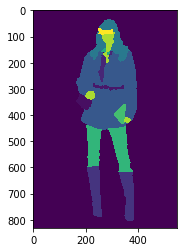

In [42]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
%matplotlib inline


annotation = loadmat("./clothing-co-parsing/annotations/pixel-level/0001.mat")['groundtruth']
image = mpimg.imread('./clothing-co-parsing/photos/0001.jpg')
imshow(image)
plt.show()
plt.imshow(annotation)
print(annotation[100, 250:300])
label_list = loadmat('./clothing-co-parsing/label_list.mat')
# print(label_list['label_list'][0][19])
# print(label_list['label_list'][0][41])
print(image.shape)
print(annotation.shape)


# print(label_list['label_list'][0][55])
# print(label_list['label_list'][0])
annotation = loadmat("./clothing-co-parsing/annotations/pixel-level/0003.mat")['groundtruth']
image = mpimg.imread('./clothing-co-parsing/photos/0003.jpg')
imshow(image)
plt.show()
plt.imshow(annotation)
print(annotation[100, 250:300])
label_list = loadmat('./clothing-co-parsing/label_list.mat')
# print(label_list['label_list'][0][19])
# print(label_list['label_list'][0][41])
print(image.shape)
print(annotation.shape)

In [20]:
# define all pixel having a label will be marked as 1, other than that 0. 

import sys
sys.path.append("/anaconda2/envs/deep-learning/bin/python3")

import os
import numpy as np
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
ANNOTATION_PATH = './clothing-co-parsing/annotations/pixel-level/'
N_train_start = 0 
N_train_end = 1004
N_test_start = 1005
N_test_end = 1105

def process(file_path, has_mask, start, end):
    file_path = Path(file_path)
    files = sorted(list(Path(file_path).iterdir()))
    datas = []
    for file in tqdm(files[start:end]): # only process N_train images.
        item = {}
        imgs = []
        img = io.imread(file)        
        file_id = str(file).split('/')[-1].split('.')[0]
        if has_mask:
            mask_file = os.path.join(ANNOTATION_PATH, file_id + '.mat')
            this_mask = loadmat(mask_file)['groundtruth']
            this_mask[this_mask > 0] = 1 # set all annotation be same label.
            item['mask'] = t.from_numpy(this_mask)
        item['name'] = file_id
        item['img'] = t.from_numpy(img)
        datas.append(item)
    return datas

if not os.path.exists(TRAIN_PATH):
    train_data = process('./clothing-co-parsing/photos/', True, N_train_start, N_train_end)
    t.save(train_data, TRAIN_PATH)
else:
    train_data = t.load(TRAIN_PATH)

if not os.path.exists(TEST_PATH):
    test_data = process('./clothing-co-parsing/photos/', False, N_test_start, N_test_end)
    t.save(test_data, TEST_PATH)
else:
    test_data = t.load(TEST_PATH)


100%|██████████| 100/100 [00:00<00:00, 134.97it/s]

In [15]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
#         self.datas = train_data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

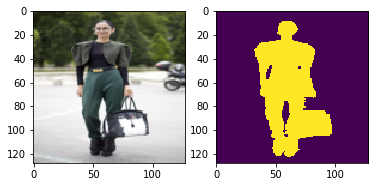

In [21]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())
plt.savefig('train.png')

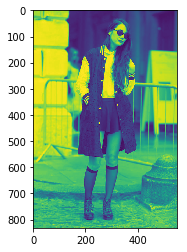

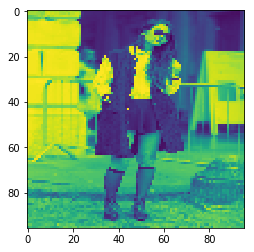

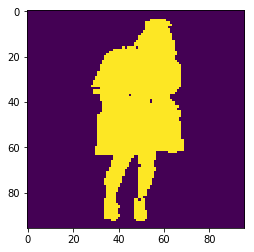

In [19]:
from __future__ import print_function

import os
import numpy as np

from skimage.io import imsave, imread
from skimage.transform import resize
from pathlib import Path
from tqdm import tqdm
from skimage import io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2


# data_path = 'raw/'

image_rows = 96
image_cols = 96

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
ANNOTATION_PATH = './clothing-co-parsing/annotations/pixel-level/'
MODEL_PATH = './checkpoints/'
N_EPOCH = 250
N_train_start = 0 
N_train_end = 1004
N_test_start = 1005
N_test_end = 1015



file_path = './clothing-co-parsing/photos/'
imgs = np.ndarray((N_train_end - N_train_start, image_rows, image_cols), dtype=np.uint8)
imgs_mask = np.ndarray((N_train_end - N_train_start, image_rows, image_cols), dtype=np.uint8)

file_path = Path(file_path)
files = sorted(list(Path(file_path).iterdir()))
datas = []
i = 0

length = 550

# for file in tqdm(files[N_train_start:N_train_end]): # only process N_train images.
for file in files[0:1]: # only process N_train images.
    img = cv2.imread(str(file), 0)
#     img = img[140:140+length, :]
    imshow(img)
    plt.show()
    imgs[i] = cv2.resize(img, dsize=(image_rows, image_cols), interpolation=cv2.INTER_CUBIC)
    imshow(imgs[i])
    plt.show()
    file_id = str(file).split('/')[-1].split('.')[0]

    mask_file = os.path.join(ANNOTATION_PATH, file_id + '.mat')
    this_mask = loadmat(mask_file)['groundtruth']
    this_mask[this_mask > 0] = 1 # set all annotation be same label.
#     imgs_mask[i] = resize(this_mask, (image_rows, image_cols), preserve_range=True)
    imgs_mask[i] = cv2.resize(this_mask, dsize=(image_rows, image_cols), interpolation=cv2.INTER_CUBIC)
    imshow(imgs_mask[i])
    plt.show()
    i += 1
# np.save('imgs_train.npy', imgs)
# np.save('imgs_mask_train.npy', imgs_mask)
# print('Saving to .npy files done.')